# LASSO Regression In-Class Exercise

In this exercise, we will see how to use LASSO for pitch detection and denoising in audio.

We load the following packages.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.io.wavfile import read

## Generate the Data

The data is generated from extracting samples of the `viola.wav` file.

In [17]:
# Read the file
# sr, yfull = read('viola_sample.p')

# Convert to floating point values so that compuations below do not overflow
# yfull = yfull.astype(float)
fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit05_lasso/viola_sample.p'
fn_dst = 'viola_sample.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

with open(fn_dst,'rb') as fp:
    t,y = pickle.load(fp)
# sr, yfull = read('viola_sample')
# yfull = yfull.astype(float)

File viola_sample.p is already downloaded


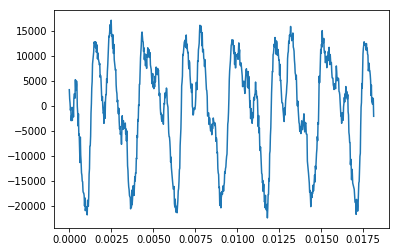

In [28]:
# sr, yfull = read('viola_sample.p')

# Convert to floating point values so that compuations below do not overflow
# yfull = yfull.astype(float)
# I = np.arange(100000,100000+800)
y0 = y
nt = len(y0)
# t = np.arange(nt)/sr
plt.plot(t,y0)

We then add a small amount of noise.

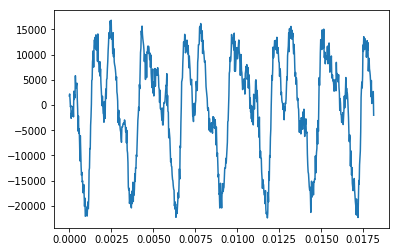

In [29]:
snrfs = 20
ystd = np.std(y)
wstd = 10**(-0.05*snrfs)*ystd
w = np.random.normal(0,wstd,nt)
y = y0 + w

plt.plot(t,y)

In [30]:
fn_dst = 'viola_sample.p'
with open(fn_dst,'wb') as fp:
    pickle.dump([t,y], fp)

## Load the Data

The data is taken from a sample of about 20 ms of audio from a viola.  I have already pre-processed the data.  You can load it with the following command.  The value `t` is the time (in seconds) and `y` is the sample of audio (this is a mono recording).  Noise has been artificially added to the sample.

In [31]:
fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit05_lasso/viola_sample.p'
fn_dst = 'viola_sample.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

with open(fn_dst,'rb') as fp:
    t,y = pickle.load(fp)

File viola_sample.p is already downloaded


Plot the data `y` vs. `t`.  

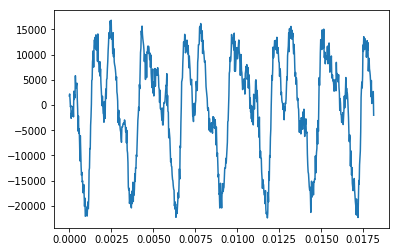

In [32]:
# TODO
plt.plot(t,y)

## Creating Features for a Sinusoidal Model

We will try to fit a model of the form:

    y[i] = \sum_j a[j]*sin(2*pi*freq[j]*t[i]) + b[j]*cos(2*pi*freq[j]*t[i])

That is, `y[i]` is a sum of sinusoids.  This is a common model for audio signals since an instrument, such as a viola, produces discrete tones.  

This model is non-linear in the frequency parameters.  So, instead of trying to find the frequencies, we will fix a large number of frequencies and then require that the coefficients `a[j]` and `b[j]` are mostly sparse.  

We will use the following vector of frequencies.  This vector includes frequencies on the muscial scale as well as frequencies between the musical notes.

In [36]:
freq = 55*2**(np.arange(5*96)/96)
freq.shape

(480,)

To fit the sinusoidal model, we will write a function to map the values `t` to 
the `sin` and `cos` features.  Finish the function `transform` that creates matrices:

    Xcos[i,j] = np.cos(2*np.pi*t[i]*freq[j])
    Xsin[i,j] = np.sin(2*np.pi*t[i]*freq[j])
    X = np.hstack((Xcos,Xsin))
    
So, if `freq` is length `d`, there will `2*d` features.  You can try to create the matrices using python broadcasting if you want to avoid a for loop.    

In [34]:
def transform(t,freq):
    # TODO
    # Xcos = ...
    # Xsin = ...
    Xcos = np.cos(2*np.pi*t[:,None]*freq[None,:])
    Xsin = np.sin(2*np.pi*t[:,None]*freq[None,:])
    
    X = np.hstack((Xcos,Xsin))    
    return X

Split the data `t` and `y` into training and test.  Use approximately 50% for each set.

In [35]:
from sklearn.model_selection import train_test_split

# TODO
ttr, tts, ytr, yts = train_test_split(t,y,test_size=0.5)

Transform the `ttr`, `tts` into `Xtr` and `Xts`.

In [39]:
# TODO
Xtr = transform(ttr,freq)
Xts = transform(tts,freq)
Xts.shape


(400, 960)

## Use LASSO to Find the Frequencies

We can now use LASSO regression to find the model
* Use LASSO regression with `alpha=500` to fit the model.  
* Find the R^2-score on the test data.
* Plot the predicted value of `y` for `t in [0,0.02]`.

In [40]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# TODO
# regr = Lasso(...)
regr = Lasso(alpha=500)
regr.fit(Xtr,ytr)
yhat = regr.predict(Xts)

rsq = r2_score(yts, yhat)
print(rsq)

0.9282080581764598


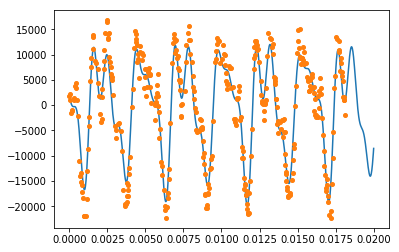

In [41]:
tp = np.linspace(0,0.02,1000)
Xp = transform(tp,freq)
yp = regr.predict(Xp)

plt.plot(tp,yp)
plt.plot(tts,yts,'o',markersize=4)

Recall that you can find the coefficient in the model via `w = regr.coef_`.  If `freq` has `d` terms, then `w` will have `2*d` terms.
* Split the coefficients `w` into `a` and `b`, the terms for the `cos` and `sin` features.
* Plot `a` and `b` using `plt.stem`.
* Which frequencies is dominant in this track?


Dominant freq = 367.332579


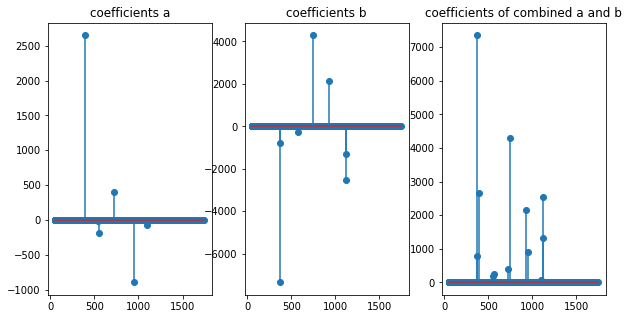

In [51]:
# TODO
w = regr.coef_
d = len(freq)
wcos = w[:d]
wsin = w[d:]

plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.stem(freq, wcos)
plt.title('coefficients a')
plt.subplot(1,3,2)
plt.stem(freq,wsin)
plt.title('coefficients b')

wabs = np.sqrt(wcos**2 + wsin**2)
plt.subplot(1,3,3)
plt.stem(freq,wabs)
plt.title('coefficients of combined a and b')
im = np.argmax(wabs)
freqm = freq[im]

print('Dominant freq = %f' % freqm)

## Selecting the Optimal Alpha

Still have time...
* Find the optimal `alpha` using cross-validation

In [52]:
from sklearn.model_selection import KFold

alphas = np.logspace(0,4,20)
nalpha = len(alphas)
nfold = 5
kf = KFold(n_splits=nfold,shuffle=True)

X = transform(t,freq)

# R^2 for each alpha and fold value
rsq = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = y[Itr]
    X_ts = X[Its,:]
    y_ts = y[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Create a LASSO model object
        model = Lasso(alpha=a)
        
        # Fit the model on the training data
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        rsq[ia,ifold] = r2_score(y_ts, y_ts_pred)
        
        print('alpha=%f %d rsq=%7.4f' % (a,ia,rsq[ia,ifold]))


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.000000 0 rsq= 0.9557


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.623777 1 rsq= 0.9557


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=2.636651 2 rsq= 0.9552


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=4.281332 3 rsq= 0.9546


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=6.951928 4 rsq= 0.9541


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=11.288379 5 rsq= 0.9541


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=18.329807 6 rsq= 0.9541


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=29.763514 7 rsq= 0.9542


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=48.329302 8 rsq= 0.9541
alpha=78.475997 9 rsq= 0.9533


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=127.427499 10 rsq= 0.9509


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=206.913808 11 rsq= 0.9460
alpha=335.981829 12 rsq= 0.9359
alpha=545.559478 13 rsq= 0.9134
alpha=885.866790 14 rsq= 0.8714
alpha=1438.449888 15 rsq= 0.7707
alpha=2335.721469 16 rsq= 0.5316
alpha=3792.690191 17 rsq= 0.2631
alpha=6158.482111 18 rsq=-0.0173
alpha=10000.000000 19 rsq=-0.0173


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.000000 0 rsq= 0.9643


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.623777 1 rsq= 0.9643


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=2.636651 2 rsq= 0.9642


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=4.281332 3 rsq= 0.9641


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=6.951928 4 rsq= 0.9639


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=11.288379 5 rsq= 0.9638


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=18.329807 6 rsq= 0.9641


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=29.763514 7 rsq= 0.9645


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=48.329302 8 rsq= 0.9648


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=78.475997 9 rsq= 0.9646
alpha=127.427499 10 rsq= 0.9624


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=206.913808 11 rsq= 0.9568
alpha=335.981829 12 rsq= 0.9471
alpha=545.559478 13 rsq= 0.9288
alpha=885.866790 14 rsq= 0.8868
alpha=1438.449888 15 rsq= 0.7894
alpha=2335.721469 16 rsq= 0.5686
alpha=3792.690191 17 rsq= 0.2881
alpha=6158.482111 18 rsq=-0.0002
alpha=10000.000000 19 rsq=-0.0002


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.000000 0 rsq= 0.9493


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.623777 1 rsq= 0.9490


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=2.636651 2 rsq= 0.9485


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=4.281332 3 rsq= 0.9480


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=6.951928 4 rsq= 0.9472


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=11.288379 5 rsq= 0.9467


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=18.329807 6 rsq= 0.9465


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=29.763514 7 rsq= 0.9462


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=48.329302 8 rsq= 0.9458


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=78.475997 9 rsq= 0.9456


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=127.427499 10 rsq= 0.9440


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=206.913808 11 rsq= 0.9409
alpha=335.981829 12 rsq= 0.9334
alpha=545.559478 13 rsq= 0.9141
alpha=885.866790 14 rsq= 0.8727
alpha=1438.449888 15 rsq= 0.7753
alpha=2335.721469 16 rsq= 0.5589
alpha=3792.690191 17 rsq= 0.2914
alpha=6158.482111 18 rsq=-0.0072
alpha=10000.000000 19 rsq=-0.0072


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.000000 0 rsq= 0.9616


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.623777 1 rsq= 0.9613


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=2.636651 2 rsq= 0.9609


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=4.281332 3 rsq= 0.9604


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=6.951928 4 rsq= 0.9598


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=11.288379 5 rsq= 0.9596


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=18.329807 6 rsq= 0.9597


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=29.763514 7 rsq= 0.9595


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=48.329302 8 rsq= 0.9587


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=78.475997 9 rsq= 0.9571


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=127.427499 10 rsq= 0.9530


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=206.913808 11 rsq= 0.9457
alpha=335.981829 12 rsq= 0.9350
alpha=545.559478 13 rsq= 0.9121
alpha=885.866790 14 rsq= 0.8663
alpha=1438.449888 15 rsq= 0.7586
alpha=2335.721469 16 rsq= 0.5078
alpha=3792.690191 17 rsq= 0.2596
alpha=6158.482111 18 rsq=-0.0038
alpha=10000.000000 19 rsq=-0.0038


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.000000 0 rsq= 0.9531


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=1.623777 1 rsq= 0.9532


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=2.636651 2 rsq= 0.9533


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=4.281332 3 rsq= 0.9534


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=6.951928 4 rsq= 0.9534


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=11.288379 5 rsq= 0.9534


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=18.329807 6 rsq= 0.9538


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=29.763514 7 rsq= 0.9542


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=48.329302 8 rsq= 0.9547


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=78.475997 9 rsq= 0.9550


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=127.427499 10 rsq= 0.9538


E:\ML_NEW\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha=206.913808 11 rsq= 0.9493
alpha=335.981829 12 rsq= 0.9397
alpha=545.559478 13 rsq= 0.9185
alpha=885.866790 14 rsq= 0.8696
alpha=1438.449888 15 rsq= 0.7623
alpha=2335.721469 16 rsq= 0.5426
alpha=3792.690191 17 rsq= 0.2783
alpha=6158.482111 18 rsq=-0.0100
alpha=10000.000000 19 rsq=-0.0100


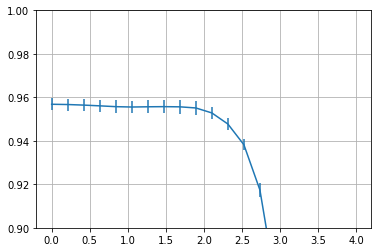

In [57]:
rsq_mean = np.mean(rsq,axis=1)
rsq_se = np.std(rsq,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(alphas),rsq_mean,yerr=rsq_se)
plt.ylim([0.9,1])
plt.grid()

array([[0.95641074, 0.96425949, 0.96447368, 0.97029229, 0.97881606],
       [0.95636148, 0.96413283, 0.96430132, 0.97030224, 0.97832028],
       [0.95630311, 0.96390633, 0.9639879 , 0.97025815, 0.97725768],
       [0.95612859, 0.96357764, 0.96347485, 0.97012973, 0.97549074]])